In [22]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import subprocess
from statsmodels.stats.multitest import multipletests


In [24]:
# def summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_PFC_Glut*.csv*",celltype='PFC_Glut'):
#     mast_files = glob.glob(file)
#     df_all = pd.DataFrame()
#     for f in mast_files:
#         df = pd.read_csv(f, index_col=0)
#         df_h = df[(df.component=="H") & (df['Pr(>Chisq)'] < 0.05)]
#         df_lfc = df[(df.component=='logFC') & (df['contrast'] =='exprimentMW') ]
#         df_dar = df_h.loc[:,["primerid","Pr(>Chisq)"]].merge(df_lfc.loc[:,['primerid','ci.hi','ci.lo','coef','z']], on='primerid', how='left').dropna(axis=1, how='all').dropna()
#         df_all = pd.concat([df_all, df_dar])
#     # correct the pvalue by Benjamini-Hochberg method from scipy
#     df_all['p_adj'] = multipletests(df_all['Pr(>Chisq)'], method='fdr_bh')[1]


#     df_all = df_all[df_all.p_adj < 0.05].sort_values('coef')
#     df_all_annotated = utils.annotate_region(df_all,region_col='primerid', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')
#     df_all_annotated.rename(columns={'gene_name':'gene'}, inplace=True)
#     df_all_annotated['condition'] = 'MW'
#     df_all_annotated.loc[df_all_annotated.coef>0,'condition'] = 'MC'
#     df_all_annotated['ctname'] = celltype
#     return df_all_annotated
# df_GABA = summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_GABA*.csv*",celltype='PFC_GABA')
# df_Glut = summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_PFC_Glut*.csv*",celltype='PFC_Glut')
# df_mast_cov = pd.concat([df_GABA, df_Glut])

In [25]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [26]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [27]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

/tmp/ipykernel_1953319/3437822688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg_select['condition'] = 'MW'


In [28]:
df_wil = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv')
df_mementob_old = pd.read_csv('/data2st1/junyi/output/atac0416/cCRE/df_deg_mento_annotated.csv')

In [29]:
df_memento_cov = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_cov = df_memento_cov[df_memento_cov.de_pval<0.05]

In [30]:
df_memento_cr = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_annotated.csv')
df_memento_cr = df_memento_cr[df_memento_cr.de_pval<0.05]
df_memento_dbatch = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_dbatch = df_memento_dbatch[df_memento_dbatch.de_pval<0.05]

In [31]:
df_result_all = pd.DataFrame()

In [32]:
df_wil.rename(columns={'gene_name': 'gene'}, inplace=True)
d_degdar_wil = df_wil.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))
d_degdar_wil.sort_values(by='condition', ascending=False, inplace=True)
d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges'] = d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges']*-1
for ctname in d_degdar_wil.ctname.unique():
    df_ct = d_degdar_wil[d_degdar_wil.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]

    corr = df_ct[['logfoldchanges', 'de_coef']].corr().iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_wil.gene)))

    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "wilcoxon"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct)}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.04,size=6834, IoU=0.05
Correlation for PFC_GABA: 0.45,size=72, IoU=0.00
Correlation for AMY_Glut: 0.52,size=143, IoU=0.01
Correlation for HIP_Glut: -0.06,size=1466, IoU=0.05
Correlation for AMY_GABA: 0.03,size=185, IoU=0.01
Correlation for HIP_GABA: nan,size=1, IoU=0.00


In [33]:
d_degdar_wil[['logfoldchanges','de_coef']].corr()

,logfoldchanges,de_coef
logfoldchanges,1.000000,0.636427
de_coef,0.636427,1.000000


In [34]:
df_memento_cov.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cov = df_memento_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cov.ctname.unique():
    df_ct = df_degmemento_cov[df_degmemento_cov.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cov[df_memento_cov.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.02,size=3624, IoU=0.23
Correlation for PFC_GABA: 0.02,size=1471, IoU=0.13
Correlation for HIP_Glut: 0.54,size=1606, IoU=0.12
Correlation for HIP_GABA: 0.01,size=966, IoU=0.10
Correlation for AMY_GABA: 0.48,size=974, IoU=0.09
Correlation for AMY_Glut: 0.79,size=1207, IoU=0.09


In [35]:
df_degmemento_cov[['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.317278
de_coef_sc,0.317278,1.000000


In [36]:
df_memento_cr.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cr = df_memento_cr.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cr.ctname.unique():
    df_ct = df_degmemento_cr[df_degmemento_cr.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cr[df_memento_cr.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)

Correlation for PFC_Glut: 0.27,size=1285, IoU=0.07
Correlation for PFC_GABA: 0.72,size=407, IoU=0.03
Correlation for HIP_GABA: 0.03,size=907, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1924, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2085, IoU=0.14
Correlation for AMY_GABA: 0.27,size=2087, IoU=0.18


In [37]:
df_ct

,names,tx_atac,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,ctname,region_atac,...,tx_sc,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj_sc,gender,region_sc
11028,chrY:90808579-90809080,stim,0.380647,0.043897,3.929259e-18,0.225278,0.207518,0.265410,AMY_GABA,AMY,...,stim,0.087314,0.016365,2.296956e-06,0.070052,0.055222,0.129933,5.779839e-06,M,AMY
11029,chr15:102405693-102406194,stim,0.156376,0.018137,5.731753e-18,0.025769,0.080989,0.714645,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
11030,chr15:102405138-102405639,stim,0.090925,0.028387,1.492973e-03,0.181510,0.146189,0.218818,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
11031,chr19:6979822-6980323,stim,0.172960,0.020871,8.501984e-17,0.061106,0.084109,0.403089,AMY_GABA,AMY,...,stim,0.149490,0.018914,6.359217e-13,0.214568,0.073242,0.007385,3.367072e-12,M,AMY
11032,chr2:33130916-33131417,stim,0.205368,0.025147,2.593453e-16,-0.010704,0.088182,0.881032,AMY_GABA,AMY,...,stim,0.245860,0.016178,1.561301e-47,0.046988,0.049371,0.296846,7.654049e-46,M,AMY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14351,chr14:66832093-66832594,stim,-0.141111,0.065911,3.191182e-02,-0.333589,0.342869,0.300649,AMY_GABA,AMY,...,stim,-0.073489,0.013120,1.066094e-08,-0.004605,0.062545,0.995918,3.517350e-08,M,AMY
14352,chr5:120673566-120674067,stim,-0.134685,0.063048,3.206719e-02,-0.048258,0.215997,0.820072,AMY_GABA,AMY,...,stim,-0.060969,0.023068,7.232491e-03,-0.048082,0.060524,0.439087,1.110047e-02,M,AMY
14353,chr13:55692809-55693310,stim,-0.075559,0.036365,3.921320e-02,0.082659,0.165782,0.604999,AMY_GABA,AMY,...,stim,-0.093010,0.024482,8.029967e-05,0.048929,0.075306,0.603919,1.658531e-04,M,AMY
14354,chr4:24897773-24898274,stim,-0.075465,0.037697,4.372140e-02,0.353154,0.174773,0.045477,AMY_GABA,AMY,...,stim,-0.160398,0.019377,6.300452e-17,0.033534,0.062440,0.762661,4.911877e-16,M,AMY


In [38]:
# df_degmast = df_mast_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
# for ctname in df_degmast.ctname.unique():
#     df_ct = df_degmast[df_degmast.ctname == ctname]
#     df_s_deg = df_deg[df_deg.ctname == ctname]
#     df_s_dar = df_mast_cov[df_mast_cov.ctname == ctname]
#     corr = df_ct[['coef', 'de_coef']].corr(method='pearson').iloc[0, 1]
#     IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
#     print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
#     row = pd.DataFrame({
#         'ctname': ctname,
#         'corr': corr,
#         'IoU': IoU,
#         'size': len(df_ct),
#         'method': "mast"
#     }, index=[0])
#     df_result_all = pd.concat([df_result_all, row], ignore_index=True)
# df_degmast[['coef','de_coef']].corr()

In [39]:

df_memnto_cr_repeat = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index()

In [40]:
df_memnto_cr_repeat.rename(columns={'ctname': 'n_celltype'}, inplace=True)

In [41]:
df_memnto_cr_ct = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(
    ['condition','gene']).aggregate(lambda x: '/'.join(set(x))).reset_index()

In [42]:
df_memnto_cr_repeat = df_memnto_cr_ct.merge(df_memnto_cr_repeat, how='inner', on=['condition', 'gene'])

In [43]:
df_memnto_cr_repeat.sort_values(by='n_celltype', ascending=False, inplace=True)

In [44]:
df_memnto_cr_repeat.rename(columns={'ctname': 'darct'}, inplace=True)

In [45]:
#df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

In [46]:
df_degmemento_cr_repeat = df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index().sort_values(by='ctname', ascending=False)

In [47]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [48]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'})

,n_celltype,n_cell
0,1,13756
1,2,10918
2,3,4907
3,4,1963
4,5,204
5,6,27


<Axes: ylabel='n_cell'>

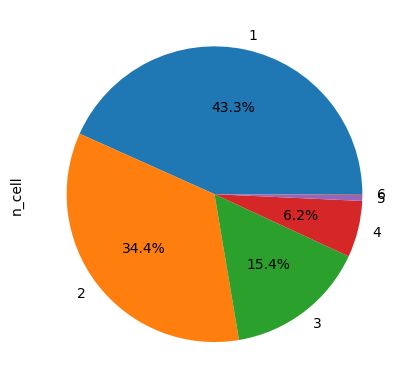

In [49]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'}).set_index('n_celltype').plot.pie(
    y='n_cell',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


In [50]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [51]:
df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).count().reset_index()

,condition,gene,ctname
0,MC,1110038F14Rik,2
1,MC,1110059E24Rik,1
2,MC,1500004A13Rik,3
3,MC,1500009L16Rik,1
4,MC,1500011B03Rik,1
...,...,...,...
5923,MW,Znhit1,1
5924,MW,Znrf2,1
5925,MW,Zscan22,2
5926,MW,Zswim6,1


In [52]:
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_dbatch = df_memento_dbatch.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_dbatch.ctname.unique():
    df_ct = df_degmemento_dbatch[df_degmemento_dbatch.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_dbatch[df_memento_dbatch.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_batch_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1189, IoU=0.07
Correlation for PFC_GABA: 0.68,size=358, IoU=0.03
Correlation for HIP_Glut: 0.72,size=1944, IoU=0.13
Correlation for HIP_GABA: 0.02,size=902, IoU=0.09
Correlation for AMY_GABA: 0.25,size=2067, IoU=0.18
Correlation for AMY_Glut: 0.74,size=2101, IoU=0.14


In [53]:
df_mementob_old.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmementob_old = df_mementob_old.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmementob_old.ctname.unique():
    df_ct = df_degmementob_old[df_degmementob_old.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_mementob_old[df_mementob_old.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1267, IoU=0.07
Correlation for PFC_GABA: 0.69,size=404, IoU=0.03
Correlation for HIP_GABA: 0.01,size=941, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1904, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2108, IoU=0.15
Correlation for AMY_GABA: 0.25,size=2099, IoU=0.18


In [54]:
df_result_all

,ctname,corr,IoU,size,method
0,PFC_Glut,0.038048,0.053931,6834,wilcoxon
1,PFC_GABA,0.448743,0.003133,72,wilcoxon
2,AMY_Glut,0.524133,0.006141,143,wilcoxon
3,HIP_Glut,-0.057854,0.049938,1466,wilcoxon
4,AMY_GABA,0.034897,0.007811,185,wilcoxon
5,HIP_GABA,NaN,0.000044,1,wilcoxon
6,PFC_Glut,0.022370,0.234669,7314,memento_cr_cov
7,PFC_GABA,0.015662,0.129080,1920,memento_cr_cov
8,HIP_Glut,0.538453,0.119219,2300,memento_cr_cov
9,HIP_GABA,0.011188,0.095653,1063,memento_cr_cov


<Axes: xlabel='ctname', ylabel='corr'>

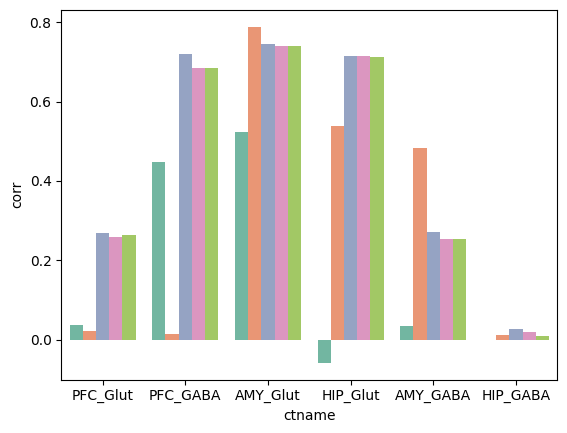

In [55]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='corr',
    hue='method',
    legend=False,
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

<Axes: xlabel='ctname', ylabel='IoU'>

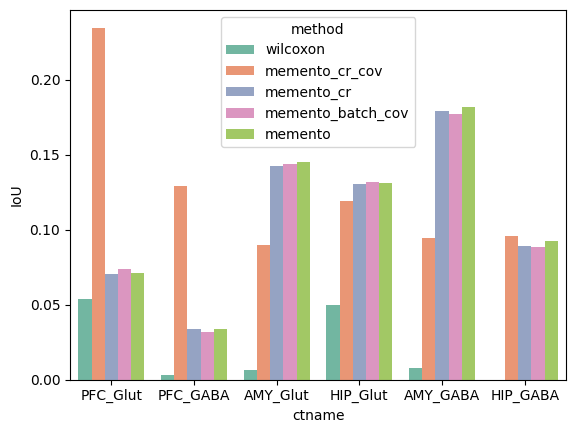

In [56]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='IoU',
    hue='method',
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

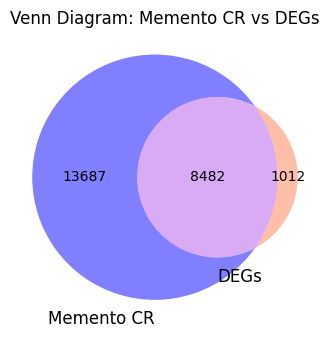

In [67]:
# Draw venn dirgram of memento_cr and deg
# color palette
from matplotlib_venn import venn2
def draw_venn(df1, df2, title1, title2):
    set1 = set(df1.gene)
    set2 = set(df2.gene)
    venn_labels = {'10': len(set1 - set2), '01': len(set2 - set1), '11': len(set1 & set2)}
    plt.figure(figsize=(4, 4))
    venn2(subsets=venn_labels, set_labels=(title1, title2), alpha=0.5, set_colors=('blue', 'coral'))
    plt.title(f'Venn Diagram: {title1} vs {title2}')
    plt.show()
draw_venn(df_memento_cr, df_deg_select, 'Memento CR', 'DEGs')


In [37]:
df_memento_cr['regulation'] = df_memento_cr['condition'].apply(lambda x: 'Up' if x == 'MC' else 'Down')

In [38]:
df_memento_cr['celltype.L1'] = df_memento_cr['ctname'].apply(lambda x: x.split('_')[-1])

In [39]:
df_memento_cr.columns

Index(['names', 'tx', 'de_coef', 'de_se', 'de_pval', 'dv_coef', 'dv_se',
       'dv_pval', 'ctname', 'region', 'condition', 'gene', 'gene_id', 'gstart',
       'gend', 'strand', 'annotation_x', 'distance', 'de_pval_adj',
       'primary_region', 'secondary_region', 'regulation', 'celltype.L1'],
      dtype='object')

In [ ]:
#df_memento_cr.drop(['regularion'],axis=1,inplace=True)

KeyError: "['regularion'] not found in axis"

In [ ]:
#df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).rename(columns={'darct': 'Neu_subtype','n_celltype':'#Neuron_type'}).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

PermissionError: [Errno 13] Permission denied: '/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv'

In [44]:
df_memento_cr

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,...,gend,strand,annotation_x,distance,de_pval_adj,primary_region,secondary_region,regulation,celltype.L1,ctname_con
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,...,98664083,+,genebody,0,3.038415e-12,exon,LINE,Up,Immune,PFC_Immune_Up
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,...,143797796,+,genebody,35278,3.114843e-12,distal,LINE,Up,Immune,PFC_Immune_Up
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,...,103750211,+,genebody,0,3.496496e-12,intron,LINE,Up,Immune,PFC_Immune_Up
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,...,98664083,+,genebody,0,5.274371e-12,exon,repeat,Up,Immune,PFC_Immune_Up
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,...,20815779,-,genebody,0,1.072659e-10,exon,cpg,Up,Immune,PFC_Immune_Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441249,chr13:98316774-98317275,stim,-0.093560,0.047568,4.964940e-02,0.077941,0.208111,0.741855,AMY_GABA,AMY,...,98324415,+,genebody,0,1.344347e-01,promoter,cpg,Down,GABA,AMY_GABA_Down
441250,chr7:80688678-80689179,stim,-0.104519,0.053277,4.972339e-02,-0.302131,0.229897,0.191148,AMY_GABA,AMY,...,80688877,-,genebody,0,1.345883e-01,promoter,cpg,Down,GABA,AMY_GABA_Down
441251,chr17:66123319-66123820,stim,-0.100798,0.053496,4.980623e-02,0.086841,0.205283,0.619451,AMY_GABA,AMY,...,66152174,+,genebody,0,1.347595e-01,UTR,cpg,Down,GABA,AMY_GABA_Down
441252,chr5:57716510-57717011,stim,-0.139860,0.070286,4.997954e-02,-0.236434,0.346212,0.444463,AMY_GABA,AMY,...,57720201,-,genebody,0,1.351111e-01,exon,NaN,Down,GABA,AMY_GABA_Down


/tmp/ipykernel_1604206/2206052668.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

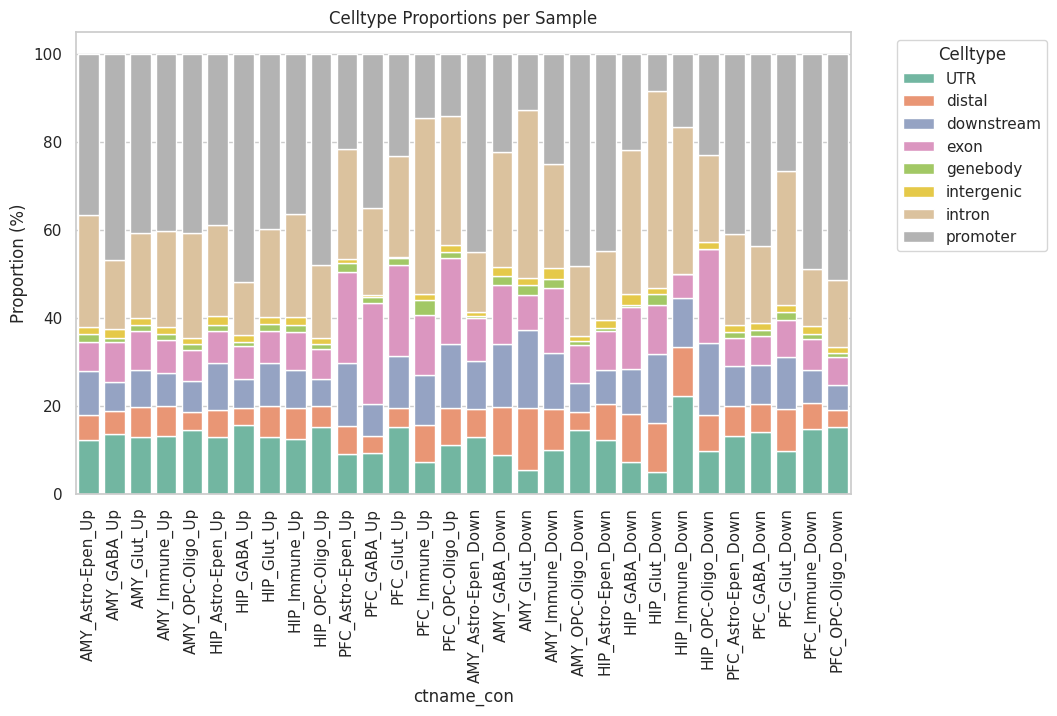

In [100]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i]
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

#order = meta_atac.sort_values('Region')['sample'].unique()
df_memento_cr['ctname_con'] = df_memento_cr['region'].astype(str) +"_"+ df_memento_cr['ctname'].str.split('_').str[-1].astype(str) + "_" + df_memento_cr['regulation'].astype(str)
order = df_memento_cr.sort_values(by=['regulation','region','celltype.L1'],ascending=[False,True,True]).drop_duplicates(['ctname_con'])['ctname_con'].to_list()
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="primary_region",x_order=order, figsize=(10, 6))

In [73]:
import PyComplexHeatmap as pch
df_ctname_con = df_memento_cr.sort_values(by=['regulation','region','celltype.L1']).drop_duplicates(['ctname_con'])['ctname_con'].reset_index()

In [77]:
df_ctname_con['Celltype.L1'] = df_ctname_con['ctname_con'].str.split('_').str[1]
df_ctname_con['Regulation'] = df_ctname_con['ctname_con'].str.split('_').str[2]
df_ctname_con['Region'] = df_ctname_con['ctname_con'].str.split('_').str[0]

In [79]:
df_ctname_con.set_index('ctname_con', inplace=True)

In [84]:
df_ctname_con = df_ctname_con.loc[order]
df_ctname_con.head()

,index,Celltype.L1,Regulation,Region
ctname_con,,,,
AMY_Astro-Epen_Down,406291,Astro-Epen,Down,AMY
AMY_GABA_Down,440548,GABA,Down,AMY
AMY_Glut_Down,416680,Glut,Down,AMY
AMY_Immune_Down,396466,Immune,Down,AMY
AMY_OPC-Oligo_Down,385730,OPC-Oligo,Down,AMY


In [99]:
order

['AMY_Astro-Epen_Down',
 'AMY_GABA_Down',
 'AMY_Glut_Down',
 'AMY_Immune_Down',
 'AMY_OPC-Oligo_Down',
 'HIP_Astro-Epen_Down',
 'HIP_GABA_Down',
 'HIP_Glut_Down',
 'HIP_Immune_Down',
 'HIP_OPC-Oligo_Down',
 'PFC_Astro-Epen_Down',
 'PFC_GABA_Down',
 'PFC_Glut_Down',
 'PFC_Immune_Down',
 'PFC_OPC-Oligo_Down',
 'AMY_Astro-Epen_Up',
 'AMY_GABA_Up',
 'AMY_Glut_Up',
 'AMY_Immune_Up',
 'AMY_OPC-Oligo_Up',
 'HIP_Astro-Epen_Up',
 'HIP_GABA_Up',
 'HIP_Glut_Up',
 'HIP_Immune_Up',
 'HIP_OPC-Oligo_Up',
 'PFC_Astro-Epen_Up',
 'PFC_GABA_Up',
 'PFC_Glut_Up',
 'PFC_Immune_Up',
 'PFC_OPC-Oligo_Up']

Starting plotting HeatmapAnnotations


/tmp/ipykernel_1604206/3229660983.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


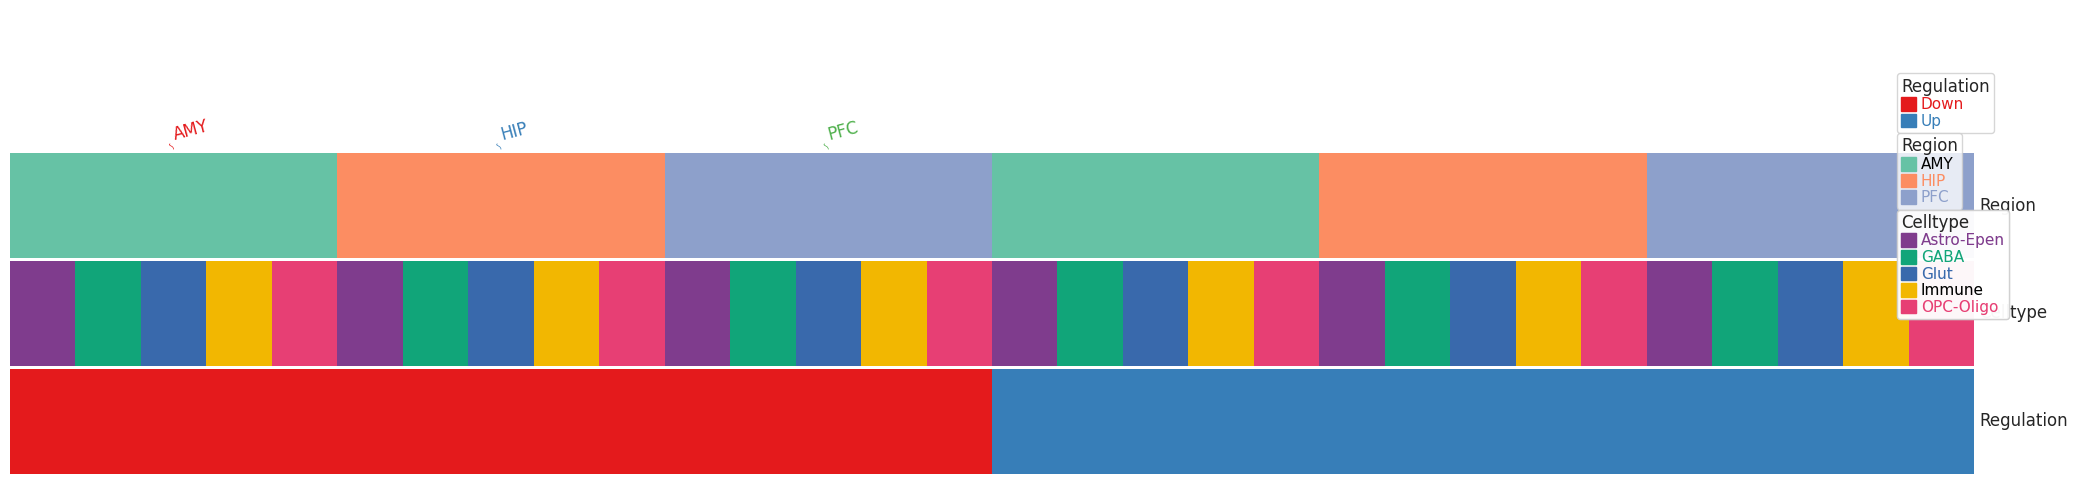

In [125]:
plt.figure(figsize=(20, 5))
col_ha = pch.HeatmapAnnotation(
                                label=pch.anno_label(df_ctname_con['Region'], merge=True,rotation=15),
                                #Sample_name=pch.anno_simple(ntc.reset_index()['sample'],legend=True), axis=1,

                                 #Sample_name=pch.anno_simple(meta_atac.Sample_name,add_text=True,legend=True),
                                Region=pch.anno_simple(df_ctname_con['Region'], add_text=False,legend=True,text_kws={'color':'black'},cmap='Set2'),
                                Celltype=pch.anno_simple(df_ctname_con['Celltype.L1'], add_text=False,legend=True,text_kws={'color':'black'},cmap='Bold'),
                                Regulation=pch.anno_simple(df_ctname_con['Regulation'], add_text=False,legend=True,text_kws={'color':'black'},cmap='Set1'),

                            #    pro=pch.anno_barplot(df=df_pro.iloc[:,1:],legend=True,cmap='tab10',stacked=True),
                               plot=True,legend=False,legend_gap=0,hgap=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1604206/1073179329.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

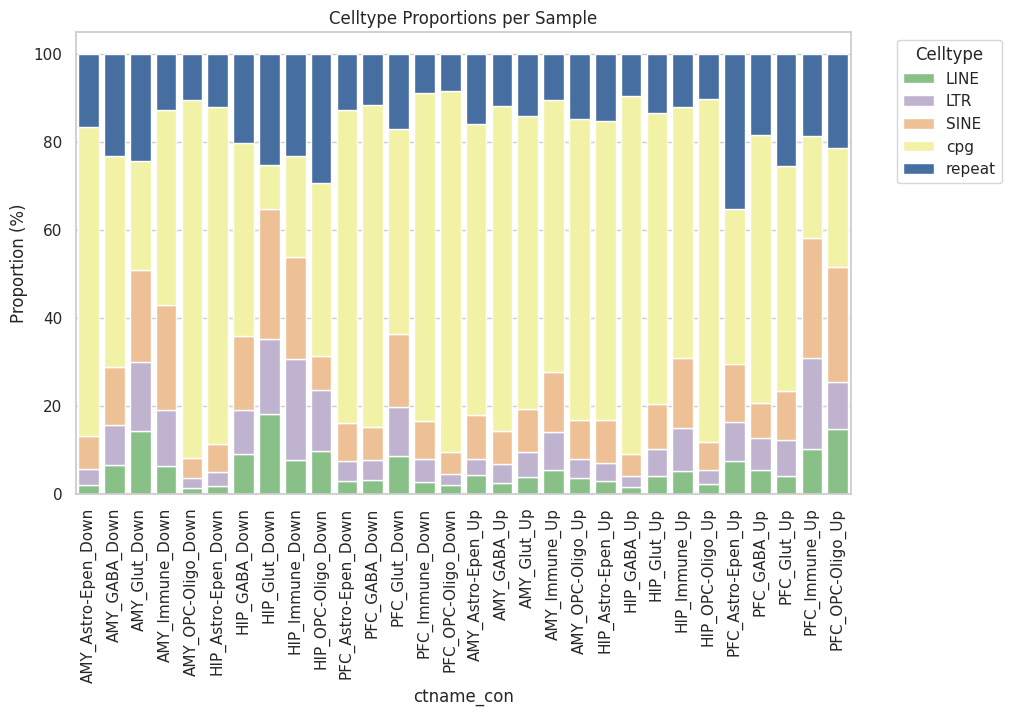

In [65]:
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="secondary_region",x_order=order,color_palette=sns.color_palette("Accent"), figsize=(10, 6))

In [ ]:
df_memento_cr.to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_cr_annotated.csv', index=False)

In [ ]:
celltypes = ['Glut', 'GABA']
regions = ['AMY', 'HIP', 'PFC']
condtion = ['MC', 'MW']

for celltype in celltypes:
    for region in regions:
        for con in condtion:
        # read the network genertaed by CICRE
            region2 = region+"_"+region
            df_network = pd.read_csv(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network.csv', index_col=0)
            distance = df_network.Peak1.str.split('_').str[1].astype(int) -df_network.Peak2.str.split('_').str[1].astype(int)
            distance[distance.abs()<500_000].abs().hist(bins=100)
            plt.axvline(x=np.median(distance[distance.abs()<500_000].abs()), color='r', linestyle='-' )  # y=position, color, linestyle
        # plt.text(np.median(distance[distance.abs()<500_000].abs()) +10000, 25000, , color='k')  # Position text at (x=1, y=5.1)
            plt.title(f'Median distance:{np.median(distance[distance.abs()<500_000].abs())}')
            plt.savefig(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network_distance.png')
            plt.close()


In [ ]:
df_network